In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
np.set_printoptions(precision=3, suppress=True)

print(pd.__version__)

1.4.0


# 1. Thử với 1 chunk nhỏ dữ liệu

**Đọc dữ liệu các sản phẩm đã được bán trong các order**

In [2]:
N = 5e5
filepath = r'C:\Users\Hoanpc.TSTDESK01\Desktop\order_products__train.csv'
order_products = pd.read_csv(filepath, chunksize=N, usecols=['product_id'])
chunk = next(order_products)
chunk

,product_id
0,49302
1,11109
2,10246
3,49683
4,43633
...,...
499995,43086
499996,4503
499997,11733
499998,2480


**Đọc danh sách các sản phẩm và aisle tương ứng**

In [3]:
filepath = r'C:\Users\Hoanpc.TSTDESK01\Desktop\Python\B9\instacart-data\products.csv'
product_info = pd.read_csv(filepath)
product_info.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [4]:
product_aisle = product_info[['product_id', 'aisle_id']]
product_aisle

,product_id,aisle_id
0,1,61
1,2,104
2,3,94
3,4,38
4,5,5
...,...,...
49683,49684,124
49684,49685,42
49685,49686,112
49686,49687,41


In [5]:
pd.merge(chunk, product_aisle, on='product_id')

,product_id,aisle_id
0,49302,120
1,49302,120
2,11109,108
3,11109,108
4,11109,108
...,...,...
499995,18657,133
499996,10905,100
499997,29739,20
499998,13969,20


In [6]:
order_aisle = pd.merge(chunk, product_aisle, on='product_id')['aisle_id']
order_aisle

0         120
1         120
2         108
3         108
4         108
         ... 
499995    133
499996    100
499997     20
499998     20
499999     19
Name: aisle_id, Length: 500000, dtype: int64

In [7]:
order_aisle.value_counts().reset_index()

,index,aisle_id
0,83,54999
1,24,54178
2,123,28389
3,120,19904
4,21,15076
...,...,...
129,103,157
130,102,126
131,82,111
132,113,109


# 2. Thực hiện với nhiều chunk

In [8]:
N = 5e5

def Select_Aisle_ID(order_pro_id):
    #print(order_pro_id.head())
    product_aisle = product_info[['product_id', 'aisle_id']]
    order_aisle = pd.merge(order_pro_id, product_aisle, on='product_id')['aisle_id']
    aisle_count = order_aisle.value_counts().reset_index()
    aisle_count.columns = ['aisle_id', 'counts']
    # print(aisle_count.shape)
    return aisle_count
    

filepath = r'C:\Users\Hoanpc.TSTDESK01\Desktop\order_products__train.csv'
order_products = pd.read_csv(filepath, chunksize=N, usecols=['product_id'])

# Xử lý chunk đầu tiên
chunk = next(order_products)
total_aisle_count = Select_Aisle_ID(chunk)

# Xử lý các chunk tiếp theo rồi ghép kết quả vào
# kết quả đầu tiên
for i, chunk in enumerate(order_products):
    if i > 12: break
    chunk_count = Select_Aisle_ID(chunk)
    total_aisle_count = pd.concat([total_aisle_count, chunk_count])

print(total_aisle_count.shape)
print(total_aisle_count.head())

(402, 2)
   aisle_id  counts
0        83   54999
1        24   54178
2       123   28389
3       120   19904
4        21   15076


In [9]:
total_aisle_count = total_aisle_count.groupby('aisle_id').sum().reset_index()
total_aisle_count.head()

,aisle_id,counts
0,1,2936
1,2,3873
2,3,17449
3,4,9917
4,5,2905


In [10]:
n_aisle_id = total_aisle_count.nlargest(10, columns='counts')
n_aisle_id

,aisle_id,counts
82,83,150609
23,24,150473
122,123,78493
119,120,55240
20,21,41699
114,115,36617
83,84,32644
106,107,31269
90,91,26240
111,112,23635


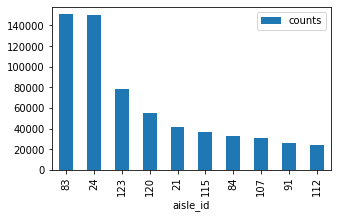

In [11]:
n_aisle_id.plot.bar(x='aisle_id', y='counts', figsize=(5,3))
plt.show()
plt.close('all')

In [12]:
filepath = r'C:\Users\Hoanpc.TSTDESK01\Desktop\Python\B9\instacart-data\aisles.csv'
aisle_info = pd.read_csv(filepath)
aisle_info.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [13]:
n_aisle_name = pd.merge(n_aisle_id, aisle_info, on='aisle_id')
n_aisle_name

,aisle_id,counts,aisle
0,83,150609,fresh vegetables
1,24,150473,fresh fruits
2,123,78493,packaged vegetables fruits
3,120,55240,yogurt
4,21,41699,packaged cheese
5,115,36617,water seltzer sparkling water
6,84,32644,milk
7,107,31269,chips pretzels
8,91,26240,soy lactosefree
9,112,23635,bread


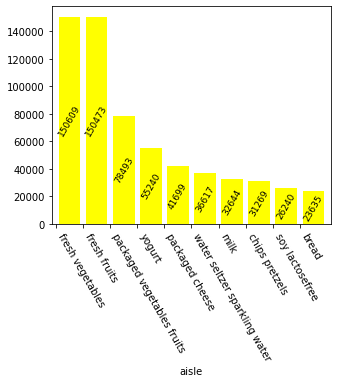

In [14]:
ax = n_aisle_name.plot.bar(x='aisle', y='counts', width=0.8, figsize=(5,4), 
                           color='yellow', legend=None, rot=-60)
ax.bar_label(container=ax.containers[0], label_type='center', fontsize=9, rotation=60)
ax.set_xticks(n_aisle_name.index-0.5)
ax.set_xticklabels(n_aisle_name['aisle'], ha='left')
plt.show()
plt.close('all')